Convolutional Forest Experiment (ConvRF)

The goal of this experiment is to demonstrate the capabilities of a convolutional forest against benchmarks such as naive random forests, simple CNN's, and more complex CNN's. We will perform 45 2-class Cifar classification tasks, and then plot the pairwise Cohen's Kappa Statistic differences between ConvRF vs naive RF, ConvRF vs a simple CNN, and ConvRF vs a more complex CNN.
Note: this experiment uses the class file and functions from /functions/ConvRF.py

In [1]:
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import Conv.ConvRF as ConvRF
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings("ignore")

First we set the plotting figure parameters and some other multiprocessing necessities.

In [2]:
plt.rcParams["legend.loc"] = "best"
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline
names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# filter python warnings
def run():
    torch.multiprocessing.freeze_support()
    print('loop')

if __name__ == '__main__':
    run()
    

loop


Next we obtain the Cifar dataset.

In [3]:
# prepare CIFAR data

# normalize
scale = np.mean(np.arange(0, 256))
normalize = lambda x: (x - scale) / scale

# train data
cifar_trainset = datasets.CIFAR10(root='./Conv/data', train=True, download=True, transform=None)
cifar_train_images = normalize(cifar_trainset.data)
cifar_train_labels = np.array(cifar_trainset.targets)

# test data
cifar_testset = datasets.CIFAR10(root='./Conv/data', train=False, download=True, transform=None)
cifar_test_images = normalize(cifar_testset.data)
cifar_test_labels = np.array(cifar_testset.targets)


# transform
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root='./Conv/data', train=True,
                                        download=True, transform=transform)
testset = datasets.CIFAR10(root='./Conv/data', train=False,
                                       download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Next we define some CNN architectures. 

In [5]:
# define 3 CNN arhcitectures
class SimpleCNNOneFilter(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNNOneFilter, self).__init__()        
        self.conv1 = torch.nn.Conv2d(3, 1, kernel_size=10, stride=2)
        self.fc1 = torch.nn.Linear(144, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144)
        x = self.fc1(x)
        return(x)

class SimpleCNN32Filter(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNN32Filter, self).__init__()        
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=10, stride=2) # try 64 too, if possible
        self.fc1 = torch.nn.Linear(144*32, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144*32)
        x = self.fc1(x)
        return(x)

class SimpleCNN32Filter2Layers(torch.nn.Module):
    
    def __init__(self):
        super(SimpleCNN32Filter2Layers, self).__init__()        
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=10, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=7, stride=1)
        self.fc1 = torch.nn.Linear(36*32, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 36*32)
        x = self.fc1(x)
        return(x)


Next we define some methods for running the algorithms.

In [6]:
def cnn_train_test(cnn_model, y_train, y_test, fraction_of_train_samples, class1=3, class2=5):
    # set params
    num_epochs = 5
    learning_rate = 0.001

    class1_indices = np.argwhere(y_train==class1).flatten()
    class1_indices = class1_indices[:int(len(class1_indices) * fraction_of_train_samples)]
    class2_indices = np.argwhere(y_train==class2).flatten()
    class2_indices = class2_indices[:int(len(class2_indices) * fraction_of_train_samples)]
    train_indices = np.concatenate([class1_indices, class2_indices])

    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, num_workers=2, sampler=train_sampler)

    test_indices = np.concatenate([np.argwhere(y_test==class1).flatten(), np.argwhere(y_test==class2).flatten()])
    test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

    test_loader = torch.utils.data.DataLoader(testset, batch_size=16,
                                             shuffle=False, num_workers=2, sampler=test_sampler)

    # define model
    net = cnn_model()
    dev = torch.device("cuda:0")
    net.to(dev)
    # loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs = torch.tensor(inputs).to(dev)
            labels = torch.tensor(labels).to(dev)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # test the model
    correct = torch.tensor(0).to(dev)
    total = torch.tensor(0).to(dev)
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            labels = torch.tensor(labels).to(dev)
            images = torch.tensor(images).to(dev)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.view(-1)).sum().item()
    accuracy = float(correct) / float(total)
    return accuracy

def run_rf(model, train_images, train_labels, test_images, test_labels, fraction_of_train_samples):
    num_train_samples_class_1 = int(np.sum(train_labels==class1) * fraction_of_train_samples)
    num_train_samples_class_2 = int(np.sum(train_labels==class2) * fraction_of_train_samples)
    
    # get only train images and labels for class 1 and class 2
    train_images = np.concatenate([train_images[train_labels==class1][:num_train_samples_class_1], train_images[train_labels==class2][:num_train_samples_class_2]])
    train_labels = np.concatenate([np.repeat(0, num_train_samples_class_1), np.repeat(1, num_train_samples_class_2)])

    # get only test images and labels for class 1 and class 2
    test_images = np.concatenate([test_images[test_labels==class1], test_images[test_labels==class2]])
    test_labels = np.concatenate([np.repeat(0, np.sum(test_labels==class1)), np.repeat(1, np.sum(test_labels==class2))])

    if isinstance(model, sklearn.ensemble.RandomForestClassifier):
        train_images = train_images.reshape(-1, 32*32*3)
        test_images = test_images.reshape(-1, 32*32*3)
    model.fit(train_images, train_labels)
    # Test
    test_preds = model.predict(test_images)
    return accuracy_score(test_labels, test_preds)


def run_cnn(cnn_model, train_images, train_labels, test_images, test_labels, fraction_of_train_samples, class1=3, class2=5):
    return cnn_train_test(cnn_model, train_labels, test_labels, fraction_of_train_samples, class1, class2)

Here we actually perform the experiments.

In [ ]:
#go through 45 combinations of experiments
for class1 in range(10):
    for class2 in range(class1 + 1, 10):
        
        # accuracy vs num training samples (naive_rf)      
        naive_rf_acc_vs_n = list()
        fraction_of_train_samples_space = np.geomspace(0.01, 1, num=8)
        for fraction_of_train_samples in fraction_of_train_samples_space:
            RF = RandomForestClassifier(n_estimators=100, n_jobs = -1)
            best_accuracy = np.mean([run_rf(RF, cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples) for _ in range(2)])
            naive_rf_acc_vs_n.append(best_accuracy)           
        
           # accuracy vs num training samples (naive_rf)
        conv_rf_2_layer = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            conv_rf_2l = ConvRF.ConvRFClassifier(layers = 2, kernel_size = (10, 5), stride = (2, 1))
            best_accuracy = np.mean([run_rf(conv_rf_2l, cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples) for _ in range(2)])
            conv_rf_2_layer.append(best_accuracy)          
          
        # accuracy vs num training samples (naive_rf)
        conv_rf_apply = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            conv_rf_a = ConvRF.ConvRFClassifier(layers = 1, kernel_size = (10,), stride = (2,))
            best_accuracy = np.mean([run_rf(conv_rf_a, cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples) for _ in range(2)])
            conv_rf_apply.append(best_accuracy)
        
            
        # accuracy vs num training samples (one layer cnn (32 filters))
        cnn32_acc_vs_n = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            best_accuracy = np.mean([run_cnn(SimpleCNN32Filter, cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples) for _ in range(2)])
            cnn32_acc_vs_n.append(best_accuracy)
            
        
        # accuracy vs num training samples (two layer cnn (32 filters))
        cnn32_two_layer_acc_vs_n = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            best_accuracy = np.mean([run_cnn(SimpleCNN32Filter2Layers, cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples) for _ in range(3)])
            cnn32_two_layer_acc_vs_n.append(best_accuracy)
            
        # accuracy vs num training samples (one layer cnn)
        cnn_acc_vs_n = list()
        for fraction_of_train_samples in fraction_of_train_samples_space:
            best_accuracy = np.mean([run_cnn(SimpleCNNOneFilter, cifar_train_images, cifar_train_labels, cifar_test_images, cifar_test_labels, fraction_of_train_samples, 0, 2) for _ in range(2)])
            cnn_acc_vs_n.append(best_accuracy) 
           
        plt.rcParams['figure.figsize'] = 13, 10
        plt.rcParams['font.size'] = 25
        plt.rcParams['legend.fontsize'] = 16.5
        plt.rcParams['legend.handlelength'] = 2.5
        plt.rcParams['figure.titlesize'] = 20
        plt.rcParams['xtick.labelsize'] = 15
        plt.rcParams['ytick.labelsize'] = 15
        
        fig, ax = plt.subplots() # create a new figure with a default 111 subplot
        ax.plot(fraction_of_train_samples_space*10000, naive_rf_acc_vs_n, marker='X', markerfacecolor='red', markersize=8, color='green', linewidth=3, linestyle=":", label="Naive RF")
        ax.plot(fraction_of_train_samples_space*10000, conv_rf_apply, marker='X', markerfacecolor='red', markersize=8, color='green', linewidth=3, linestyle="--", label="Conv RF")
        ax.plot(fraction_of_train_samples_space*10000, conv_rf_2_layer, marker='X', markerfacecolor='red', markersize=8, color='green', linewidth=3, label="Conv RF 2 layer")
        
        ax.plot(fraction_of_train_samples_space*10000, cnn_acc_vs_n, marker='X', markerfacecolor='red', markersize=8, color='orange', linewidth=3, linestyle=":", label="Simple CNN")
        ax.plot(fraction_of_train_samples_space*10000, cnn32_acc_vs_n, marker='X', markerfacecolor='red', markersize=8, color='orange', linewidth=3, linestyle="--", label="CNN (32 filters)")
        ax.plot(fraction_of_train_samples_space*10000, cnn32_two_layer_acc_vs_n, marker='X', markerfacecolor='red', markersize=8, color='orange', linewidth=3, label="CNN Two Layer (32 filters)")
        
        ax.set_xlabel('Number of Train Samples', fontsize=18)
        ax.set_xscale('log')
        ax.set_xticks([i*10000 for i in list(np.geomspace(0.01, 1, num=8))])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        
        ax.set_ylabel('Accuracy', fontsize=18)
        
        ax.set_title(str(class1) + " (" + names[class1] + ") vs " + str(class2) + "(" + names[class2] + ") classification", fontsize=18)
        plt.legend()
        plt.savefig("cifar_results/" + str(class1) + "_vs_" + str(class2))
        table = pd.DataFrame(np.concatenate(([naive_rf_acc_vs_n], [conv_rf_apply], [conv_rf_2_layer], [cnn_acc_vs_n], [cnn32_acc_vs_n],[cnn32_two_layer_acc_vs_n]), axis=0))
        algos = ['naiveRF', 'convrf', 'convrf2layer', 'simplecnn', 'cnn32', 'cnn32_2layer']
        table['algos'] = algos
        cols = table.columns.tolist()
        cols = [cols[-1]] + cols[:-1]
        cols = pd.Index(cols)
        table = table[cols]
        table.to_csv("cifar_results/" + str(class1) + "_vs_" + str(class2) + ".csv", index=False)
        print("Comparing %d vs %d" % (class1, class2)


Train Fraction: 0.01
Accuracy: 0.7765
Train Fraction: 0.019306977288832496
Accuracy: 0.7987500000000001
Train Fraction: 0.0372759372031494
Accuracy: 0.82125
Train Fraction: 0.07196856730011521
Accuracy: 0.83725
Train Fraction: 0.13894954943731375
Accuracy: 0.8512500000000001
Train Fraction: 0.2682695795279725
Accuracy: 0.86425
Train Fraction: 0.517947467923121
Accuracy: 0.8765000000000001
Train Fraction: 1.0
Accuracy: 0.8835
Train Fraction: 0.01
Accuracy: 0.7435
Train Fraction: 0.019306977288832496
Accuracy: 0.7757499999999999
Train Fraction: 0.0372759372031494
Accuracy: 0.7925
Train Fraction: 0.07196856730011521
Accuracy: 0.808
Train Fraction: 0.13894954943731375
Accuracy: 0.826
Train Fraction: 0.2682695795279725
Accuracy: 0.84575


Now we plot the Kappa Statistic differences between ConvRF and a naive forest.

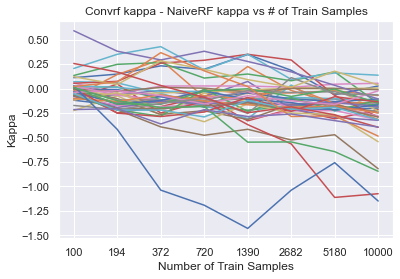

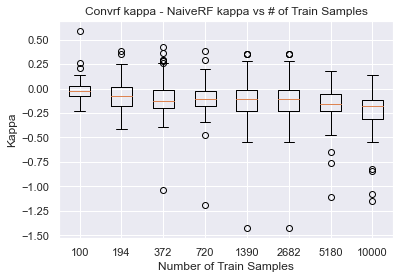

In [9]:
#convrf vs naiverf
kappas_conv_naive = []
xs = []
for class1 in range(10):
    for class2 in range(class1 + 1, 10):
        results = pd.read_csv("Conv/cifar_results/" + str(class1) + "_vs_" + str(class2) + ".csv", index_col=0)
        rf_err = .5 / (1 - results.iloc[0])
        convrf_err = .5 / (1 - results.iloc[1])
        kappa = convrf_err - rf_err
        kappas_conv_naive.extend(kappa)
        xs.extend([1, 2, 3, 4, 5, 6, 7, 8])

ind1 = range(0, len(xs), 8)
ind2 = range(1, len(xs), 8)
ind3 = range(2, len(xs), 8)
ind4 = range(3, len(xs), 8)
ind5 = range(4, len(xs), 8)
ind6 = range(5, len(xs), 8)
ind7 = range(6, len(xs), 8)
ind8 = range(7, len(xs), 8)

plt.clf()
for i in range(45):
    plt.plot(xs[i*8:i*8+8], kappas_conv_naive[i*8:i*8+8])
plt.xticks([1,2, 3, 4, 5, 6, 7, 8], ['100', '194', '372', '720', '1390', '2682', '5180', '10000'])
plt.xlabel('Number of Train Samples')
plt.ylabel('Kappa')
plt.title('Convrf kappa - NaiveRF kappa vs # of Train Samples')
plt.savefig('Conv/kappas/convrf-naiverf kappa line')

plt.figure()
plt.clf()
box1 = [(kappas_conv_naive[i]) for i in ind1]
box2 = [(kappas_conv_naive[i]) for i in ind2]
box3 = [(kappas_conv_naive[i]) for i in ind3]
box4 = [(kappas_conv_naive[i]) for i in ind4]
box5 = [(kappas_conv_naive[i]) for i in ind5]
box6 = [(kappas_conv_naive[i]) for i in ind6]
box7 = [(kappas_conv_naive[i]) for i in ind7]
box8 = [(kappas_conv_naive[i]) for i in ind8]
boxs = [box1, box2, box3, box4, box5, box5, box7, box8]

plt.boxplot(boxs)
plt.xlabel('Number of Train Samples')
plt.ylabel('Kappa')
plt.title('Convrf kappa - NaiveRF kappa vs # of Train Samples')
plt.xticks([1,2, 3, 4, 5, 6, 7, 8], ['100', '194', '372', '720', '1390', '2682', '5180', '10000'])
plt.savefig('Conv/kappas/convrf-naiverf kappa box')


Now we plot the Kappa Statistic differences between ConvRF and simple CNN.

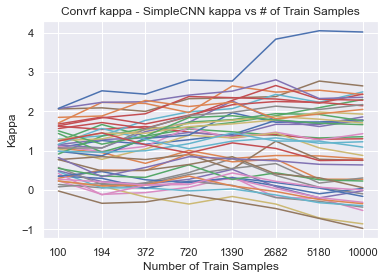

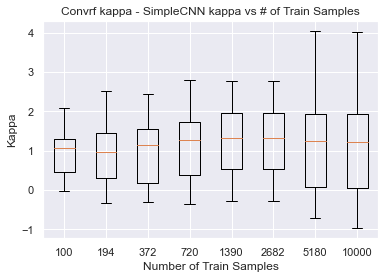

In [10]:
#ConvRF vs simple cnn
kappas_conv_cnn = []
xs = []
for class1 in range(10):
    for class2 in range(class1 + 1, 10):
        results = pd.read_csv("Conv/cifar_results/" + str(class1) + "_vs_" + str(class2) + ".csv", index_col=0)
        cnn_err = .5 / (1 - results.iloc[3])
        convrf_err = .5 / (1 - results.iloc[1])
        kappa = convrf_err - cnn_err
        kappas_conv_cnn.extend(kappa)
        xs.extend([1, 2, 3, 4, 5, 6, 7, 8])
       
plt.clf()
for i in range(45):
    plt.plot(xs[i*8:i*8+8], kappas_conv_cnn[i*8:i*8+8])
plt.xticks([1,2, 3, 4, 5, 6, 7, 8], ['100', '194', '372', '720', '1390', '2682', '5180', '10000'])
plt.xlabel('Number of Train Samples')
plt.ylabel('Kappa')
plt.title('Convrf kappa - SimpleCNN kappa vs # of Train Samples')
plt.savefig('Conv/kappas/convrf-SimpleCNN kappa scatter')

plt.figure()
plt.clf()
box1 = [(kappas_conv_cnn[i]) for i in ind1]
box2 = [(kappas_conv_cnn[i]) for i in ind2]
box3 = [(kappas_conv_cnn[i]) for i in ind3]
box4 = [(kappas_conv_cnn[i]) for i in ind4]
box5 = [(kappas_conv_cnn[i]) for i in ind5]
box6 = [(kappas_conv_cnn[i]) for i in ind6]
box7 = [(kappas_conv_cnn[i]) for i in ind7]
box8 = [(kappas_conv_cnn[i]) for i in ind8]
boxs = [box1, box2, box3, box4, box5, box5, box7, box8]

plt.boxplot(boxs)
plt.xlabel('Number of Train Samples')
plt.ylabel('Kappa')
plt.title('Convrf kappa - SimpleCNN kappa vs # of Train Samples')
plt.xticks([1,2, 3, 4, 5, 6, 7, 8], ['100', '194', '372', '720', '1390', '2682', '5180', '10000'])
plt.savefig('Conv/kappas/convrf-SimpleCNN kappa box')


Now we plot the Kappa Statistic differences between ConvRF and more complex CNN.

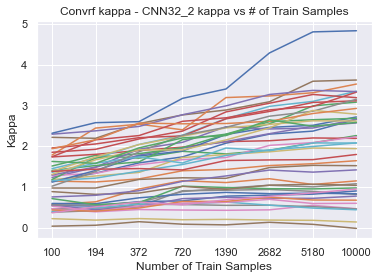

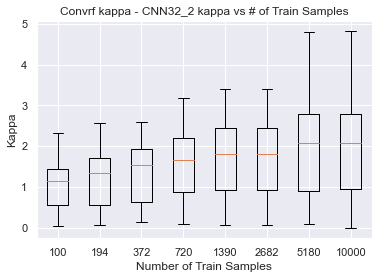

In [11]:
#ConvRF vs CNN 32 filter
kappas_conv_cnn32 = []
xs = []
for class1 in range(10):
    for class2 in range(class1 + 1, 10):
        results = pd.read_csv("Conv/cifar_results/" + str(class1) + "_vs_" + str(class2) + ".csv", index_col=0)
        cnn32_err = .5 / (1 - results.iloc[5])
        convrf_err = .5 / (1 - results.iloc[1])
        kappa = convrf_err - cnn32_err
        kappas_conv_cnn32.extend(kappa)
        xs.extend([1, 2, 3, 4, 5, 6, 7, 8])

ind1 = range(0, len(xs), 8)
ind2 = range(1, len(xs), 8)
ind3 = range(2, len(xs), 8)
ind4 = range(3, len(xs), 8)
ind5 = range(4, len(xs), 8)
ind6 = range(5, len(xs), 8)
ind7 = range(6, len(xs), 8)
ind8 = range(7, len(xs), 8)

plt.clf()
for i in range(45):
    plt.plot(xs[i*8:i*8+8], kappas_conv_cnn32[i*8:i*8+8])
plt.xticks([1,2, 3, 4, 5, 6, 7, 8], ['100', '194', '372', '720', '1390', '2682', '5180', '10000'])
plt.xlabel('Number of Train Samples')
plt.ylabel('Kappa')
plt.title('Convrf kappa - CNN32_2 kappa vs # of Train Samples')
plt.savefig('Conv/kappas/convrf-CNN32_2 kappa scatter')

plt.figure()
plt.clf()
box1 = [(kappas_conv_cnn32[i]) for i in ind1]
box2 = [(kappas_conv_cnn32[i]) for i in ind2]
box3 = [(kappas_conv_cnn32[i]) for i in ind3]
box4 = [(kappas_conv_cnn32[i]) for i in ind4]
box5 = [(kappas_conv_cnn32[i]) for i in ind5]
box6 = [(kappas_conv_cnn32[i]) for i in ind6]
box7 = [(kappas_conv_cnn32[i]) for i in ind7]
box8 = [(kappas_conv_cnn32[i]) for i in ind8]
boxs = [box1, box2, box3, box4, box5, box5, box7, box8]

plt.boxplot(boxs)
plt.xlabel('Number of Train Samples')
plt.ylabel('Kappa')
plt.title('Convrf kappa - CNN32_2 kappa vs # of Train Samples')
plt.xticks([1,2, 3, 4, 5, 6, 7, 8], ['100', '194', '372', '720', '1390', '2682', '5180', '10000'])
plt.savefig('Conv/kappas/convrf-CNN32_2 kappa box')